# Introduction

The number of data, both quantitative and qualitative, increases dramastically in the era of big data. In E-commerence industry, more and more reviews on products can be made more conveniently. Hence, it is extremely costly, if not impossible, for company to go through every review one by one manually to gain insights on the sentiment towards their products. Therefore, having a machine learning tool to analysis the huge amount data systematically and automatically could boost the company's efficieny and become essential in this era. <br> <br>
In this project, we are going to develop a machine learning model based on real-life data to help us perform sentiment analysis. The dataset consists of a nearly 3000 Amazon customer qualitative reviews, star ratings, date of review, variant and sentiment of various Amazon Alexa products.

# Acknowledgement

The dataset used in this project is retrieved from Kaggle dataset 'Amazon Alexa Reviews' contributed by Manu Siddhartha and Anurag Bhatt. You may access the dataset by https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews. <br> <br>
Besides, this project is inspired by Ryan Ahmed in the Coursera's guided project 'NLP: Twitter Sentiment Analysis', which can be accessed by https://www.coursera.org/projects/twitter-sentiment-analysis. On top of the skeleton provided, I have made the following modifications in the project:
- commenting on exploratory data analysis
- further investigating on the relation between review lengths and sentiments
- including logarithmic review length as an input feature
- adapting Logistic Regression and k-Nearest Neighbor instead of Naive Bayes
- splitting dataset into validation set also

# 1: Set Up

## 1.1: Import Libraries

In [39]:
# Basic Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Wordcloud
from wordcloud import WordCloud

# Punctuation
import string

# Natural Language Tool Kit
import nltk
from nltk.corpus import stopwords # Stopwords
nltk.download('stopwords')

# Tokenization
from sklearn.feature_extraction.text import CountVectorizer

# Model Training
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression # Logistic
from sklearn.neighbors import KNeighborsClassifier # k-Nearest Neighbor

# Model Saving and Loading
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2: Exploratory Data Analysis

## 2.1: Load Datasets

In [2]:
df = pd.read_csv('amazon_reviews.csv')

# Rename columns for clarity
df.columns = ['Rating', 'Date', 'Variation', 'Review', 'Sentiment']

The meaning of each column in the dataframe is as follows:
- Rating (int): ordinal measure on how a customer being satisfied with the product (1: worst, 5: best)
- Date (object): the date when the review was given
- Variation (object): the type of the product
- Review (object): qualititive comments of a customer on the product
- Sentiment (int): binary measure on the sentiment of the review (0: negative, 1: positive)

In [3]:
# Check a few rows of the dataframe
df.head()

,Rating,Date,Variation,Review,Sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Rating     3150 non-null   int64 
 1   Date       3150 non-null   object
 2   Variation  3150 non-null   object
 3   Review     3150 non-null   object
 4   Sentiment  3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


From the above output, we can see that there is no missing value for each column.

## 2.2: Lengths of Reviews

Sometimes, the length of a review can give us insight about the satisfaction of a customer and hence the sentiment. For example, a customer who is very upset about the product may tend to write more detailed review and be more expressive in emotion. <br> <br> Let's include this feature in our dataset to see if it is really the case later.

In [5]:
df['Length'] = df['Review'].apply(len)

In [6]:
df.head()

,Rating,Date,Variation,Review,Sentiment,Length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


## 2.3: Observations

### 2.3.1: Intuition on Sentiment

In [7]:
df.describe()

,Rating,Sentiment,Length
count,3150.000000,3150.000000,3150.000000
mean,4.463175,0.918413,132.049524
std,1.068506,0.273778,182.099952
min,1.000000,0.000000,1.000000
25%,4.000000,1.000000,30.000000
50%,5.000000,1.000000,74.000000
75%,5.000000,1.000000,165.000000
max,5.000000,1.000000,2851.000000


From the above table, we can see that the mean and the median of the 'Rating' are __intuitively__ high (above 4). But one should be aware that 'Rating' is an ordinal data. Mean and median may not be as meaningful as those of ratio scale data. <br>
Similar observations can be obtained from the column of 'Sentiment'. <br>
Hence, we have a rough idea that the reviews are generally positive.

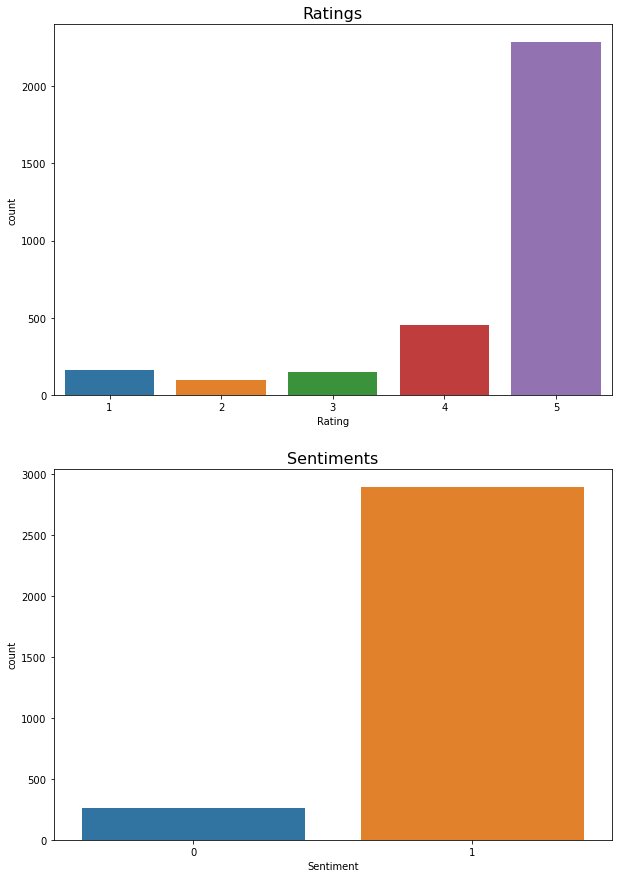

In [8]:
fig, ax = plt.subplots(figsize=[10,15], nrows=2, ncols=1)
sns.countplot(x=df['Rating'], ax=ax[0]).set_title('Ratings', size=16)
sns.countplot(x=df['Sentiment'], ax=ax[1]).set_title('Sentiments', size=16)
plt.show()

The above countplots also agree the intuition that the reviews are generally positive.

### 2.3.2: Relation between Lengths of Reviews and Sentiments

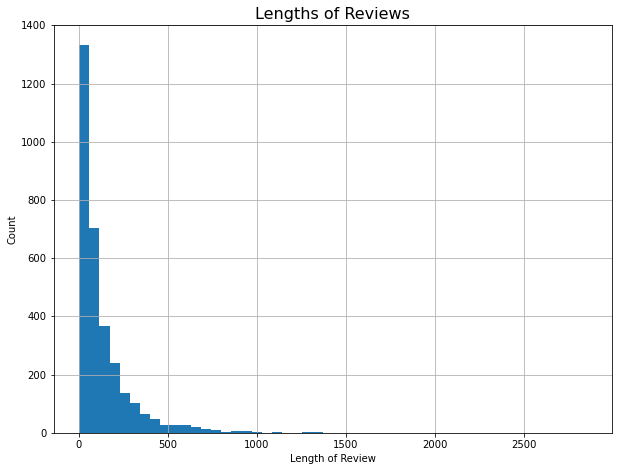

In [9]:
plt.figure(figsize=[10,7.5])
df['Length'].hist(bins=50)
plt.xlabel('Length of Review')
plt.ylabel('Count')
plt.title('Lengths of Reviews', size=16)
plt.show()

Notice that the distribution of the lengths of reviews is right-skewed. In order to have boxplot to visualize the distribution without having squeezed boxes, logrithmic scale should be applied on the "Length".

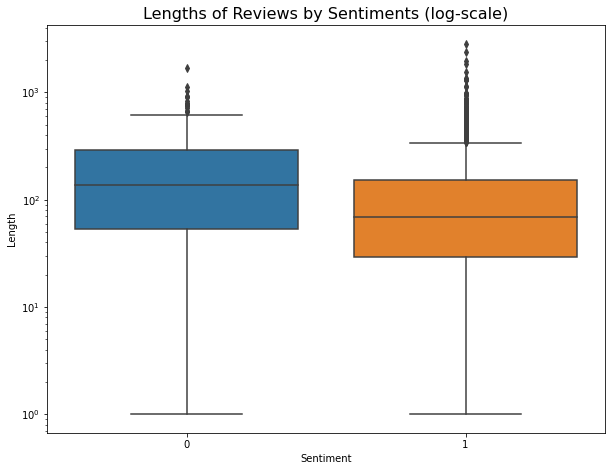

In [10]:
plt.figure(figsize=[10,7.5])
sns.boxplot(x='Sentiment', y='Length', data=df)
plt.title('Lengths of Reviews by Sentiments (log-scale)', size=16)
plt.yscale('log')
plt.show()

We can see from the above figures that negative reviews tend to have a longer review lengths, which matches our intuition. <br>

Also, at the first glance, one may think that the distribution of review lengths for high-rating reviews is more dispersed because of more outliers shown. However, notice there are much more positive reviews than netgaitves (~2800 vs ~250), resulting in more outliers in terms of magnitude. <br>
As the y-axis is in log-scale, it is hard to compare the inter-quartile range (IQR) for the two boxes by visualization. Let's try to investigate the grouped data by observing the numeric statistics.

In [11]:
report = df.groupby(by='Sentiment').describe().loc[:,'Length']
report['IQR'] = report['75%'] - report['25%']
report = report.T
display(report)

Sentiment,0,1
count,257.000000,2893.000000
mean,215.241245,124.659177
std,236.325955,174.624491
min,1.000000,1.000000
25%,53.000000,29.000000
50%,137.000000,69.000000
75%,289.000000,154.000000
max,1686.000000,2851.000000
IQR,236.000000,125.000000


From the above table, we can see that the standard deviation (std) and IQR of positive review lengths are less than those of negative review lengths. We can conclude that the lengths of positive reviews are shorter and less disperse. <br> <br>
Besides, the mean of the positive review lengths is less than that of negatives, which matches the observation we have in above.

### 2.3.3: Wordclouds

In [12]:
# Separatepositive and negative sentiment reviews
positive_df = df[df['Sentiment'] == 1]
negative_df = df[df['Sentiment'] == 0]

In [13]:
# Join all reviews into one large string
positive_big_string = " ".join(positive_df['Review'].tolist())
negative_big_string = " ".join(negative_df['Review'].tolist())

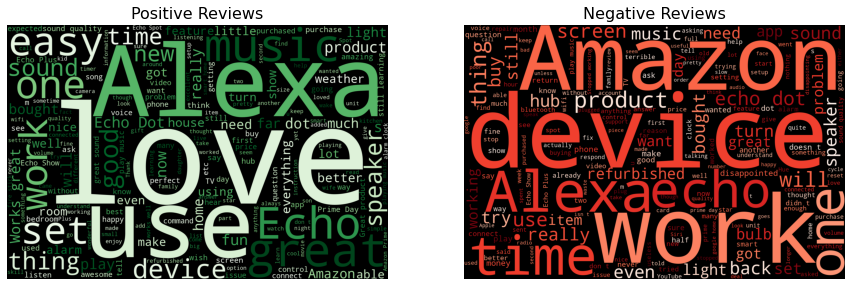

In [14]:
# Visualize Wordclouds
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[15,10])
ax[0].imshow(WordCloud(width=1500, height=1000, colormap='Greens').generate(positive_big_string))
ax[1].imshow(WordCloud(width=1500, height=1000, colormap='Reds').generate(negative_big_string))
ax[0].set_title('Positive Reviews', size=16)
ax[0].axis('off')
ax[1].set_title('Negative Reviews', size=16)
ax[1].axis('off')
plt.show()

We can see from the wordclouds that the word choice in positive and negative reviews are quite different. Hence, analyzing the qualitative reviews by Natural Language Processing (NLP) should help us to distinguish the sentiment. 

### 2.3.4: Relation between Rating and Sentiment

In [15]:
df.groupby(by='Sentiment').describe().loc[:,'Rating'].T

Sentiment,0,1
count,257.000000,2893.000000
mean,1.373541,4.737643
std,0.484688,0.546544
min,1.000000,3.000000
25%,1.000000,5.000000
50%,1.000000,5.000000
75%,2.000000,5.000000
max,2.000000,5.000000


Notice that in the above table, the maximum rating for negative reviews is 2 while the minimum rating for positive reviews is 3. It is very likely that the labellers manually decide to use 3-star rating as a cutoff to distinglish positive and negative sentiments. <br>
So, if we include 'Rating' as a feature in our prediction model, the model will probably learn the manual cut-off. So, for the purpose of predicting sentiment from the qualitative reviews, the 'Rating' column should be excluded.

# 3: Data Processing

In [16]:
input_df = df.copy()
target_df = df[['Sentiment']].copy()

## 3.1: Dropping Non-feature Columns

In [17]:
input_df.drop(['Rating', 'Date', 'Variation', 'Sentiment'], axis=1, inplace=True)

## 3.2: Normalizing Numeric Features

From Section 2.3.2, we can see the distribution of review lengths is right-skewed and hence normalizing this feature by directly applying z-score may not be applicable. <br>
Let's see if the review length distribution is log-normal.

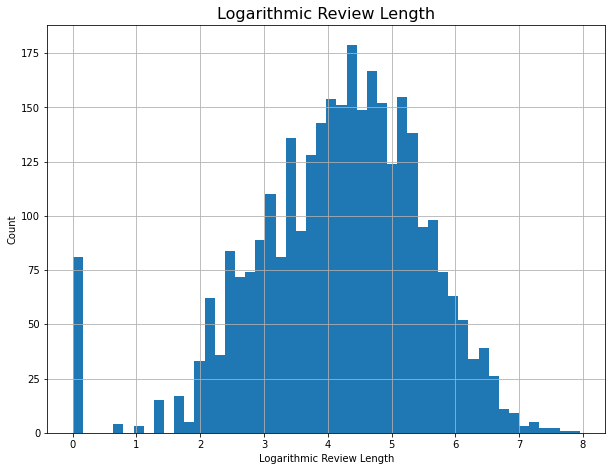

In [18]:
plt.figure(figsize=[10,7.5])
df['Length'].apply(np.log).hist(bins=50)
plt.xlabel('Logarithmic Review Length')
plt.ylabel('Count')
plt.title('Logarithmic Review Length', size=16)
plt.show()

From the above histogram, we can conclude that the distribution of logarithmic review length is approximately normal (the distribution is bell-shaped except for the first bin of 0). Taking z-scores on the logarithm review lengths will be a reasonable way to normalize this feature.

In [19]:
# Length: Log Normalization due to right-skewness
log_length = np.log(input_df['Length'])
input_df['Length'] = (log_length - log_length.mean()) / log_length.std()

## 3.3: Tokenization

### 3.3.1: Cleaning Reviews

In [20]:
def cleaning_review(review):
    # Trim and change all characters to lower case
    clean = review.strip().lower()
    
    # Remove Punctuation
    clean = clean.translate(str.maketrans('', '', string.punctuation))
    
    # Remove Stopwords
    clean = list(filter(lambda word: word not in stopwords.words('english'), clean.split()))
    
    return clean

### 3.3.2: Count Vectorizer

In [21]:
vectorizer = CountVectorizer(analyzer=cleaning_review, dtype=np.uint8)

In [22]:
# This may take around 1-2 minutes to run
reviews_countvectorizer = vectorizer.fit_transform(input_df['Review'])

In [23]:
input_df = pd.concat([input_df, pd.DataFrame(reviews_countvectorizer.toarray())], axis=1)

In [24]:
input_df.drop('Review', axis=1, inplace=True)

In [25]:
# Models below need all columns to either be str or int
input_df.columns = input_df.columns.astype(str)

# 4: Training Classification Model

We are going to split the datasets into train, validation and test sets. Train set is used to train model parameters while validation test is used to decide which models is better. After selected the optimal model, we will then use the test set to test model's performance to see if it can make accurate prediction.

## 4.1: Splitting Dataset

In [26]:
# Split Dataset into 70%, 15% and 15% for train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(input_df, target_df, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5) # Val and Test split equally for the 30%

## 4.2: Training Models

Notice that sample size of our dataset is relatively small (around 3000). Traditional Machine Learning Algorithm should work the same or even better than modern ML algorithm like Deep Neural Network. <br> <br>
We are going to try the following models to see which works best for our dataset:
- Logistic Regression
- k-Nearest Neighbor Classification

### 4.2.1: Logistic Regression

In [27]:
# Train Model
logistic = LogisticRegression(random_state=0)
logistic.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

In [28]:
# Make Prediction
y_predict_val = logistic.predict(X_val)

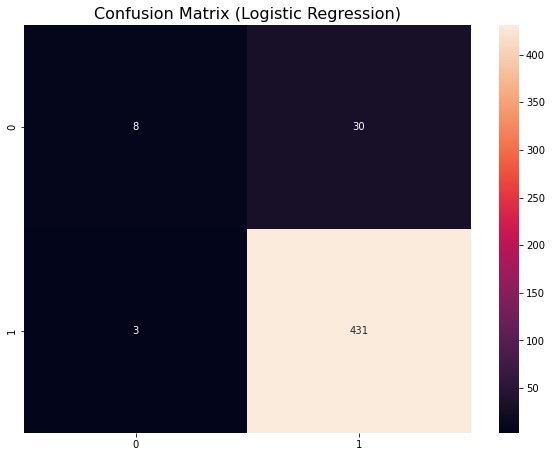

              precision    recall  f1-score   support

           0       0.73      0.21      0.33        38
           1       0.93      0.99      0.96       434

    accuracy                           0.93       472
   macro avg       0.83      0.60      0.64       472
weighted avg       0.92      0.93      0.91       472



In [33]:
# Visualize Confusion Matrix
cm_val = confusion_matrix(y_val, y_predict_val)
plt.figure(figsize=[10,7.5])
sns.heatmap(cm_val, annot=True, fmt='.3g')
plt.title('Confusion Matrix (Logistic Regression)', size=16)
plt.show()

# Model Report
print(classification_report(y_val, y_predict_val))

### 4.2.2: k-Nearest Neighbour

In [34]:
# Train Model
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=2)

In [35]:
# Make Prediction
y_predict_val = knn.predict(X_val)

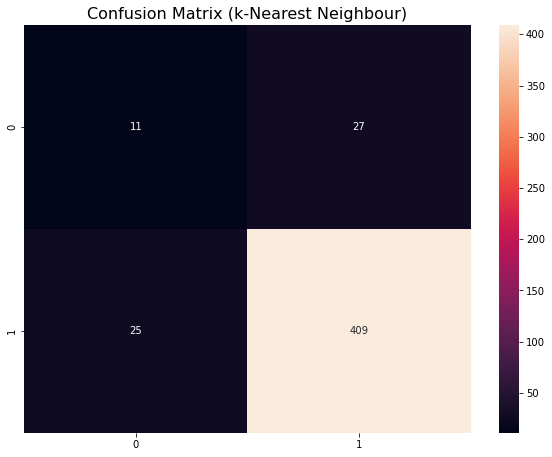

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        38
           1       0.94      0.94      0.94       434

    accuracy                           0.89       472
   macro avg       0.62      0.62      0.62       472
weighted avg       0.89      0.89      0.89       472



In [36]:
# Visualize Confusion Matrix
cm_val = confusion_matrix(y_val, y_predict_val)
plt.figure(figsize=[10,7.5])
sns.heatmap(cm_val, annot=True, fmt='.3g')
plt.title('Confusion Matrix (k-Nearest Neighbour)', size=16)
plt.show()

# Model Report
print(classification_report(y_val, y_predict_val))

Besides the models above, attempts have been made on Naive Bayes Model and Support Vector Machine. However, the former requires non-negative features (preferably integers), which does not match our logarithmic "Length" feature. The latter requires too much computation time. <br> <br>
From the above, both logistic regression and kNN model performed quite well (accuracy ~ 90%) in validation set, and both models did not trivially label all reviews positive (trivial labelling may happen in some models as the size of positive reviews dominate the dataset). <br>
To choose one, logistic model seems to be a bit better overall by considering the accuracies and f1-scores. So, we will choose the logistic model to proceed to test set. <br>
However, it is worth noticing that the recall rate for negative reviews in logistic model is worse. 

## 4.3: Test Model

In [37]:
# Make Prediction
y_predict_test = logistic.predict(X_test)

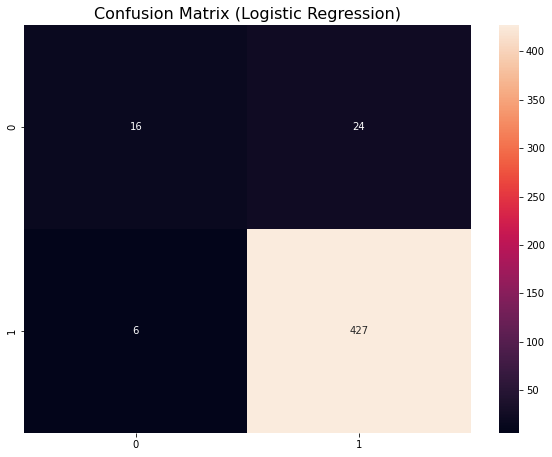

              precision    recall  f1-score   support

           0       0.73      0.40      0.52        40
           1       0.95      0.99      0.97       433

    accuracy                           0.94       473
   macro avg       0.84      0.69      0.74       473
weighted avg       0.93      0.94      0.93       473



In [41]:
# Visualize Confusion Matrix
cm_test = confusion_matrix(y_test, y_predict_test)
plt.figure(figsize=[10,7.5])
sns.heatmap(cm_test, annot=True, fmt='.3g')
plt.title('Confusion Matrix (Logistic Regression)', size=16)
plt.show()

# Model Report
print(classification_report(y_test, y_predict_test))

The test result shows that logistic model also perform a great job (accuracy ~95%) in classifying the sentiment in test set. However, the performance on the negative reviews is yet to be improved. That's may due to the relatively small amount of negative review data.

## 4.4: Save Model

In [40]:
# Save
pickle.dump(logistic, open('SentimentAnalysis.pickle', 'wb'))

# Load
#logistic = pickle.load(open('SentimentAnalysis.pickle', "rb"))

# Conclusion

To conclude, the project meets its goal, which is to develop a machine learning model to symmetrically and automatically analyze customers' sentiment towards a product based on their qualitative reviews. <br>
The model uses Logistic Regression to classify review sentiments into two classes, positive (1) or negative (0), and is trained based on around 2000 sample data, which have two main inputs: logarithmic review lengths and count of tokens of reviews without punctutions and stop words. The model is then evaluated by a validation set and a test set, each of size around 500 data, and has an accuracy in the range of 90% to 95%.

## Further Project Suggestions

Working through this project, some limitations are encountered and may give us ideas for further project investigation. Some suggestions include:
* having larger dataset, especially more negative reviews
* including 'date of review' as an input feature as customers' needs and expectations may vary due to the release of other models later
* including 'variation' or price as an input feature as different models may have different prices, which may affect customers' expectation and sentiment
* performing multi-class classification (e.g. Strongly Negative, Negative, Positive, Strongly Positive) instead of a binary one
* using N-gram model to process the reviews instead of unigram,
* including particular types of punctuation like ! and ?, instead of excluding all of them
* trying more machine learning models such as Random Forest, Support Vector Machine with a less expensive algorithm, or fine-tuning a Deep Neural Network specializing in Natural Language Processing

If you have any other suggestion, please let me know so that we can improve this project efficiency and effectiveness. Thank you!